# Point-in-Polygon queries 

Finding out if a certain point is located inside or outside of an area, or finding out if a line intersects with another line or polygon are fundamental geospatial operations that are often used e.g. to select data based on location. Such spatial queries are one of the typical first steps of the workflow when doing spatial analysis. Performing a spatial join (will be introduced later) between two spatial datasets is one of the most typical applications where Point in Polygon **(PIP)** query is used.

## How to check if point is inside a polygon? 

Computationally, detecting if a point is inside a polygon is most commonly done using a specific formula called [Ray Casting algorithm](https://en.wikipedia.org/wiki/Point_in_polygon#Ray_casting_algorithm). Luckily, we do not need to create such a function ourselves for conducting the Point in Polygon (PIP) query. Instead, we can take advantage of [Shapely’s binary predicates](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates) that can evaluate the topolocical relationships between geographical objects, such as the PIP as we’re interested here.

## Point-in-polygon queries on `shapely` geometries

There are basically two ways of conducting PIP in Shapely:

1. using a function called `within()` that checks if a point is within a polygon. 
2. using a function called `contains()` that checks if a polygon contains a point.

_**NOTE** Even though we are talking here about *Point* in Polygon operation, it is also possible to check if a LineString or Polygon is inside another Polygon._

Let’s first create a couple of point geometries:

In [1]:
import shapely.geometry
point1 = shapely.geometry.Point(24.952242, 60.1696017)
point2 = shapely.geometry.Point(24.976567, 60.1612500)

...and a polygon: 

In [2]:
polygon = shapely.geometry.Polygon(
    [
        (24.950899, 60.169158),
        (24.953492, 60.169158),
        (24.953510, 60.170104),
        (24.950958, 60.169990)
    ]
)

In [3]:
print(point1)
print(point2)
print(polygon)

POINT (24.952242 60.1696017)
POINT (24.976567 60.16125)
POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


Let's check if the points are `within()` the polygon: 

In [4]:
point1.within(polygon)

True

In [5]:
point2.within(polygon)

False

It seems that the first point is inside the polygon, but the second one is not.

We can turn the logic of the look-up around: Rather than check of the point is within the polygon, we can also ask whether the polygon `contains()` the point:

In [6]:
polygon.contains(point1) 

True

In [7]:
polygon.contains(point2)

False

**💡HINT**
_The two ways of checking the spatial relationship are complementary and yield equivalent results; `contains()` is inverse to `within()`, and vice versa._

The, which one should you use? Well, it depends: 
- if you have **many points and just one polygon** and you try to find out which one of them is inside the polygon: You might need to iterate over the points and check one at a time if it is `within()` the polygon.
- if you have **many polygons and just one point** and you want to find out which polygon contains the point: You might need to iterate over the polygons until you find a polygon that `contains()` the point specified

## Point-in-polygon queries on `geopandas.GeoDataFrame`s

In the following practical example we find which of the provided ward centers fall within a particular district in Zimbabwe. 

The data set we are using is from [Zimbabwe Geoportal](https://zimgeoportal.org.zw). 

In [8]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()

# define the absolute path to the data
input_data_directory = NOTEBOOK_PATH.parent / "input_data"
output_data_directory = NOTEBOOK_PATH.parent / "output_data"

In [9]:
import geopandas 

zwe_districts = geopandas.read_file(
    input_data_directory / "zwe_adm2.shp"
    )
zwe_districts.head()

,OBJECTID,admin2Name,admin2Pcod,admin1Name,admin1Pcod,Shape_Leng,Shape_Area,cases,recovered,deaths,in_case,geometry
0,1.0,Beitbridge,ZW1601,Matabeleland South,ZW16,6.243144,1.111672,None,None,None,None,"POLYGON ((29.90621 -21.26976, 29.91866 -21.276..."
1,2.0,Beitbridge Urban,ZW1622,Matabeleland South,ZW16,0.391538,0.007823,None,None,None,None,"POLYGON ((29.98811 -22.15274, 30.02215 -22.159..."
2,3.0,Bikita,ZW1801,Masvingo,ZW18,3.274864,0.447512,None,None,None,None,"POLYGON ((31.97352 -19.82110, 31.97389 -19.825..."
3,4.0,Bindura,ZW1201,Mashonaland Central,ZW12,3.177016,0.190533,None,None,None,None,"POLYGON ((31.29627 -16.82632, 31.37156 -16.836..."
4,5.0,Bindura Urban,ZW1221,Mashonaland Central,ZW12,0.213425,0.001697,None,None,None,None,"POLYGON ((31.36502 -17.31971, 31.36601 -17.323..."


<Axes: >

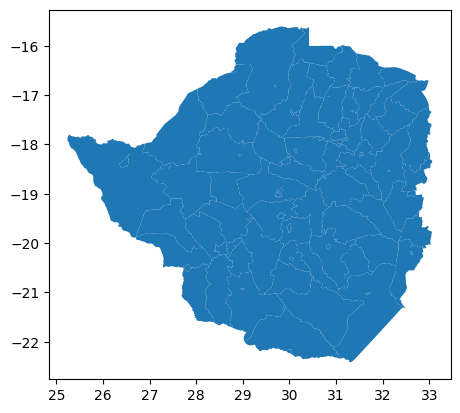

In [10]:
zwe_districts.plot()

Specifically, we want to find out which points are within the _Makoni District_. Let's start by obtaining a separate data set for this district, loading the points data and plotting a multi-layer map that shows all districts, _Makoni_ district and the ward center points in one map. 

In [12]:
makoni_district = zwe_districts[zwe_districts["admin2Name"] == "Makoni"]
makoni_district

,OBJECTID,admin2Name,admin2Pcod,admin1Name,admin1Pcod,Shape_Leng,Shape_Area,cases,recovered,deaths,in_case,geometry
49,50.0,Makoni,ZW1104,Manicaland,ZW11,5.318425,0.669709,None,None,None,None,"POLYGON ((32.56435 -17.60067, 32.56438 -17.600..."


In [29]:
import pandas as pd 

wards_df = pd.read_csv(input_data_directory / "ward_centers.csv")
wards_df.head()

,y,x
0,-18.9686,31.1668
1,-17.8274,31.0521
2,-20.1505,28.5845
3,-19.8327,32.7649
4,-18.7740,31.9430


Lets convert these coordinates into a _point_ shapefile 

In [30]:
# Get the pandas dataframe and make it a geoDataframe by using the geopandas.points_from_xy() function
wards_gdf = geopandas.GeoDataFrame(wards_df, geometry=geopandas.points_from_xy(wards_df["x"], wards_df["y"]))

# specify the coordinates reference system 
wards_gdf.crs = "EPSG:4326"

# Lets see what the Geodataframe looks like 
wards_gdf.head()

,y,x,geometry
0,-18.9686,31.1668,POINT (31.16680 -18.96860)
1,-17.8274,31.0521,POINT (31.05210 -17.82740)
2,-20.1505,28.5845,POINT (28.58450 -20.15050)
3,-19.8327,32.7649,POINT (32.76490 -19.83270)
4,-18.7740,31.9430,POINT (31.94300 -18.77400)


We can even save this as a shapefile through 

```python
wards_gdf.to_file(output_data_directory / "wards_centers.shp")
```

But lets just go straight ahead and plot this. 

The easiest way to obtain an axes is to save the first `plot()`’s return value (see below). Another option is to create `subplots()`, possibly with only one row and one column.

<Axes: >

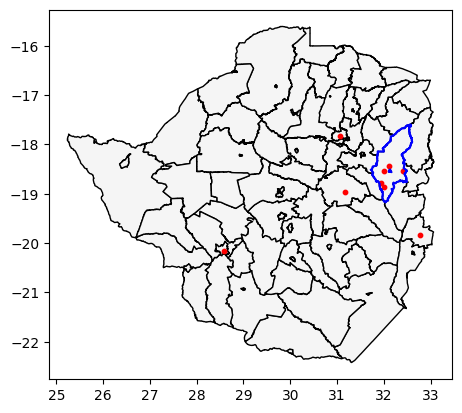

In [33]:
axes = zwe_districts.plot(color="whitesmoke", edgecolor="black")
wards_gdf.plot(ax=axes, color="red", markersize=10)
makoni_district.boundary.plot(ax=axes, color="blue")

Some _Ward Centers_ are within _Makoni District_ (in blue), but others are not. To find out which are the ones inside the district, we can use a **point-in-polygon query**, this time on the entire `geopandas.GeoDataFrame`. Its method `within` returns Boolean (`True`/`False`) values that indicate whether or not a row's geometry is contained in the supplied _other_ geometry: 

> **⚠️ geometry vs. geometry column** 
> In the example below, we use `makoni_district.iloc[0].geometry` to obtain a single value, a `shapely.geometry.Polygon`, instead of an entire column (a `GeoSeries`). This is in order to match each row's geometry of the entire `wards_centers` data frame against _the same polygon_. If, in contrast, we would run `within()` against a column, the operation would be carried out row-wise, i.e. the first ward point would be checked against the first polygon, the second ward point against the second polygon, and so forth. 
>
> Check the [documentation for `within()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.within.html) to learn more!

In [36]:
wards_gdf.within(makoni_district.iloc[0].geometry)

0    False
1    False
2    False
3    False
4     True
5     True
6     True
7     True
8     True
dtype: bool

This list of Boolean values, also called a _mask array_ can be used to filter the input data frame: 

In [37]:
wards_in_makoni = wards_gdf[wards_gdf.within(makoni_district.iloc[0].geometry)]
wards_in_makoni

,y,x,geometry
4,-18.774,31.943,POINT (31.94300 -18.77400)
5,-18.533,32.406,POINT (32.40600 -18.53300)
6,-18.870,31.993,POINT (31.99300 -18.87000)
7,-18.529,31.993,POINT (31.99300 -18.52900)
8,-18.429,32.100,POINT (32.10000 -18.42900)


Finally, lets plot this list of wards inside Makoni district one more time to visually verify that all of them, indeed are located within the "Makoni" district: 

<Axes: >

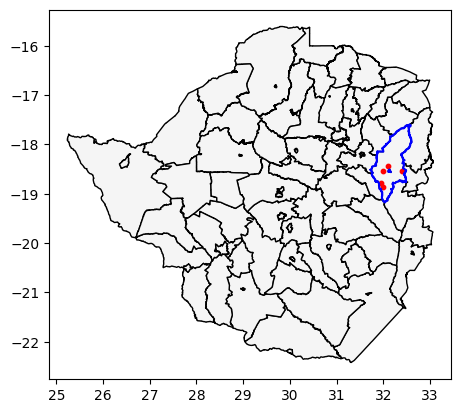

In [38]:
axes = makoni_district.boundary.plot(color="blue")
zwe_districts.plot(ax=axes, color="whitesmoke", edgecolor="black")
wards_in_makoni.plot(ax=axes, color="red", markersize=10)

Perfect! Now we are left with only the (red) points which indeed, are inside the blue boudary polygon which in this case shows _Makoni district_. **That's exactly what we wanted! Hurray!!!!** 

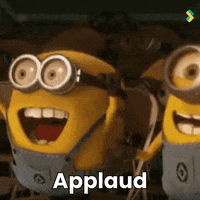